The initial model is then packed into a TF lite model. We then look at classifying more unseen pics into the relevant categories using this lite model. The initial model is relatively small so the results aren't mind-blowing, but it's a good start.

## Setup

Import TensorFlow and other necessary libraries:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load the training dataset

In [3]:
import pathlib

data_dir = pathlib.Path(r'data\03-training-batch-large-tiles-15px')

In [4]:
print(data_dir)

data\03-training-batch-large-tiles-15px


There are 4874 total images:

In [5]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

24307


Here is an example of a pipe in good condition:

In [6]:
class_zero = list(data_dir.glob('Class-0-water/*'))
PIL.Image.open(str(class_zero[0]))

In [7]:
batch_size = 32
img_height = 15
img_width = 15

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24307 files belonging to 6 classes.
Using 19446 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24307 files belonging to 6 classes.
Using 4861 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Class-0-water', 'Class-1', 'Class-2', 'Class-3', 'Class-4', 'Class-5']


## Visualize the data

Here are the first nine images from the training dataset:

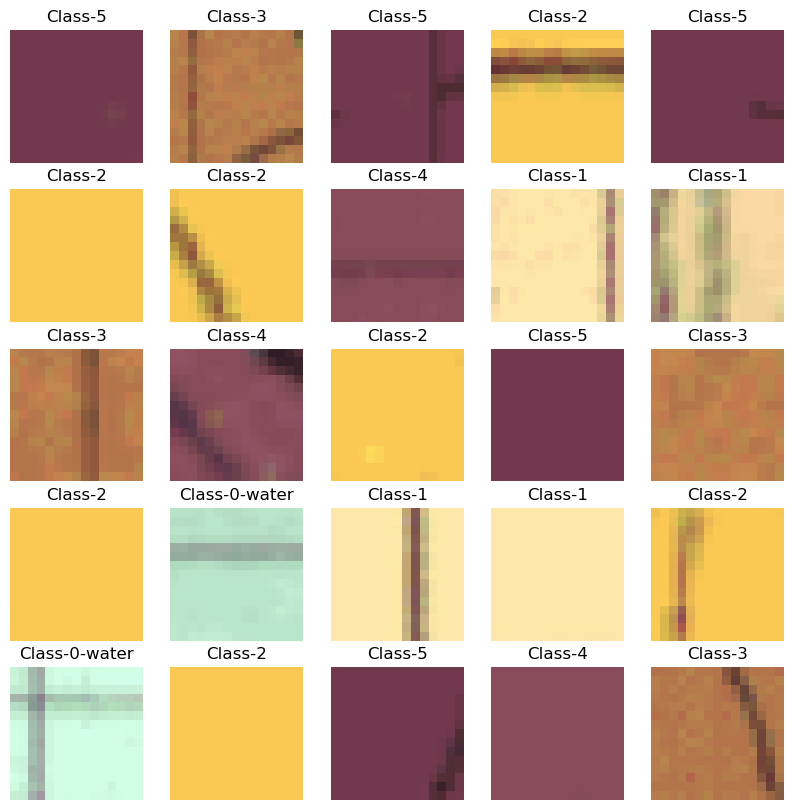

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

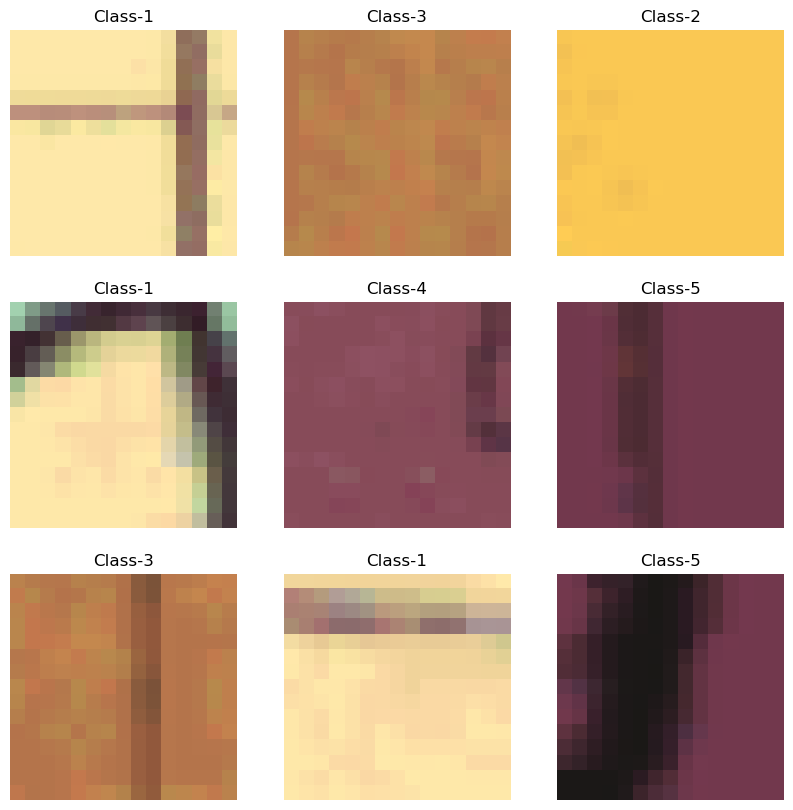

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [29]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 15, 15, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 300, 300, 3)`. This is a batch of 32 images of shape `300x300x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.


## Configure the dataset for performance



We autotune, optimise, cache and prefetch. Will help us manage resources better and reduce the risk of the feared overfitting.

In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardise the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values somewhere sub 1.0.


## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). The model is simple and only scratches the surface. We will train a more sophisticated model in the second training on a larger dataset - this might be a mistake and possibly we should have tried harder this first time around.

In [38]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
  layers.Dense(num_classes)
])

In [32]:
# num_classes = len(class_names)

# model = Sequential([
#     layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.3),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(num_classes, activation='softmax')
# ])

### Compile the model

We are going to go with the classic `tf.keras.optimizers.Adam` optimiser and `tf.keras.losses.SparseCategoricalCrossentropy` loss function.

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 15, 15, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 15, 15, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 64)         

### Train the model

Train the model for 15 epochs with the Keras `Model.fit` method:

In [41]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
608/608 [==============================] - 4s 5ms/step - loss: 0.2521 - accuracy: 0.9041 - val_loss: 0.0476 - val_accuracy: 0.9856
Epoch 2/15
608/608 [==============================] - 3s 6ms/step - loss: 0.0687 - accuracy: 0.9802 - val_loss: 0.0368 - val_accuracy: 0.9870
Epoch 3/15
608/608 [==============================] - 3s 6ms/step - loss: 0.0475 - accuracy: 0.9870 - val_loss: 0.0378 - val_accuracy: 0.9877
Epoch 4/15
608/608 [==============================] - 4s 6ms/step - loss: 0.0552 - accuracy: 0.9835 - val_loss: 0.0219 - val_accuracy: 0.9930
Epoch 5/15
608/608 [==============================] - 3s 5ms/step - loss: 0.0442 - accuracy: 0.9869 - val_loss: 0.0228 - val_accuracy: 0.9926
Epoch 6/15
608/608 [==============================] - 3s 5ms/step - loss: 0.0464 - accuracy: 0.9860 - val_loss: 0.0830 - val_accuracy: 0.9739
Epoch 7/15
608/608 [==============================] - 4s 7ms/step - loss: 0.0361 - accuracy: 0.9898 - val_loss: 0.0279 - val_accuracy: 0.9903
Epoch 

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

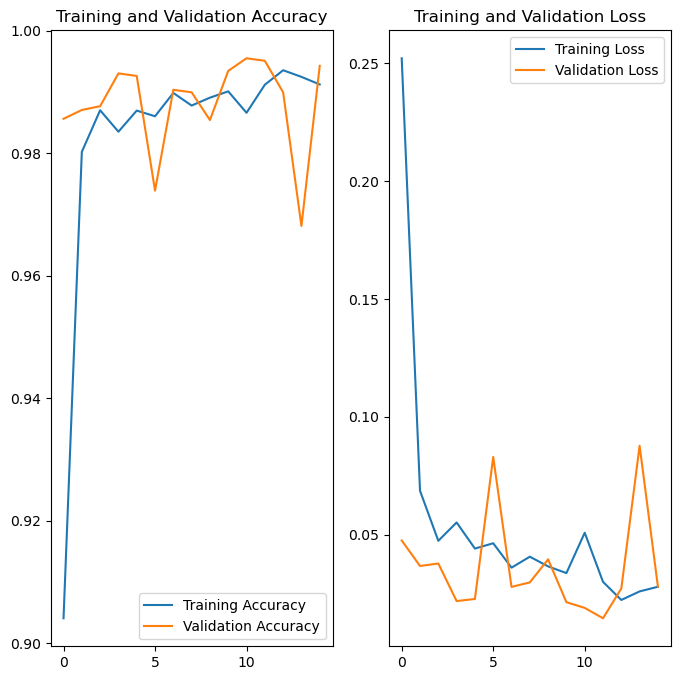

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

In this example, take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a [TensorFlow Lite](https://www.tensorflow.org/lite/) model:

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('initial-model-hi-res-15px.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\patry\AppData\Local\Temp\tmpsxynlpeg\assets


INFO:tensorflow:Assets written to: C:\Users\patry\AppData\Local\Temp\tmpsxynlpeg\assets


THe below model should allow batch processing

In [43]:
# Convert the model with dynamic batch size
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32
converter.experimental_new_converter = True

# Set the input shape to have dynamic batch size
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_new_quantizer = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]

# Ensure input shape is dynamic
def representative_data_gen():
    for _ in range(100):
        yield [np.random.rand(1, img_height, img_width, 3).astype(np.float32)]

converter.representative_dataset = representative_data_gen

tflite_model = converter.convert()

# Save the model
with open('initial-model-hi-res-15px-batched-turbo-4o.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\patry\AppData\Local\Temp\tmps32on_bs\assets


INFO:tensorflow:Assets written to: C:\Users\patry\AppData\Local\Temp\tmps32on_bs\assets
